# pol dataset 

In [12]:
# Imports
import os
import sys
BASE_DIR = os.path.dirname(os.getcwd())
sys.path.append(BASE_DIR)
import torch
import numpy as np
import pandas as pd

# Opendataval
from dataval.dataloader import Register, DataFetcher, mix_labels, add_gauss_noise
from dataval.datavaluation import NDDV, NDSV
from dataval.experiment import ExperimentMediator

import warnings
warnings.filterwarnings("ignore")

In [13]:
DataFetcher.datasets_available()

{'2dplanes',
 'MiniBooNE',
 'adult',
 'bbc',
 'bbc-embeddings',
 'breast_cancer',
 'challenge-iris',
 'cifar10',
 'cifar10-embeddings',
 'cifar100',
 'cifar100-embeddings',
 'creditcard',
 'diabetes',
 'digits',
 'echoMonths',
 'election',
 'electricity',
 'fashion',
 'fmnist-embeddings',
 'fried',
 'gaussian_classifier',
 'gaussian_classifier_high_dim',
 'imdb',
 'imdb-embeddings',
 'iris',
 'linnerud',
 'lowbwt',
 'mnist',
 'mnist-embeddings',
 'mv',
 'nomao',
 'pol',
 'stl10-embeddings',
 'stock',
 'svhn-embeddings',
 'vehicle_sensIT',
 'wave_energy',
 'webdata_wXa'}

## [Step 1] Set up an environment
`ExperimentMediator` is a fundamental concept in establishing the `opendataval` environment. It empowers users to configure hyperparameters, including a dataset, a type of synthetic noise, and a prediction model. With  `ExperimentMediator`, users can effortlessly compute various data valuation algorithms.

The following code cell demonstrates how to set up `ExperimentMediator` with a pre-registered dataset and a prediction model.
- Dataset: adult
- Model: sklearn's logistic regression model
- Metric: Classification accuracy

In [14]:
dataset_name = "cifar10-embeddings"
train_count, valid_count, test_count, meta_count = 1000, 100, 300, 100
noise_rate = 0.1
noise_kwargs = {'noise_rate': noise_rate}
max_epoch = 3
batch_size = 32
lr = 0.01
random_state = 42
train_kwargs = {"epochs": max_epoch, "batch_size": batch_size, "lr": lr}
model_name = "classifiermlp"   # "sklogreg"
# model_name = "LogisticRegression"
metric_name = "accuracy"
cache_dir = "../data_files/"
add_noise = mix_labels
noise_type = "mix_labels"
fair_type = "interact"
device = 'cpu'

exper_med = ExperimentMediator.model_factory_setup(
    dataset_name=dataset_name,
    cache_dir=cache_dir,  
    force_download=False,
    train_count=train_count,
    valid_count=valid_count,
    test_count=test_count,
    meta_count=meta_count,
    add_noise=add_noise, 
    noise_kwargs=noise_kwargs,
    train_kwargs=train_kwargs,
    random_state = random_state,
    model_name=model_name,
    metric_name=metric_name,
    device=device
)

Base line model metric_name='accuracy': perf=0.3233333230018616


## [Step 2] Compute data values
`opendataval` provides various state-of-the-art data valuation algorithms. `ExperimentMediator.compute_data_values()` computes data values.

In [30]:
# 假设fetcher.noisy_train_indices是一个包含噪声训练索引的数组
noisy_train_indices = fetcher.noisy_train_indices
print(len(noisy_train_indices))

# 创建一个包含每个标签索引的列表
label_indices = []
for i in range(fetcher.y_train.shape[1]):
    label_indices.append(np.where(fetcher.y_train[:, i] == 1)[0])
    print(len(label_indices[i]))

# 提取noisy_train_indices中那些也存在于每个label_indices[i]中的元素
common_indices = []
for i in range(len(label_indices)):
    common_indices.append(np.intersect1d(noisy_train_indices, label_indices[i]))

# 打印或处理这些公共索引
for i in range(len(common_indices)):
    print(f"Label {i}: {common_indices[i]}")
    print(len(common_indices[i]))


100
86
93
108
94
102
93
102
94
109
119
Label 0: [123 173 218 293 297 350 357 496 550 762 878]
11
Label 1: [240 442 460 532 671 780 957 986 991]
9
Label 2: [139 141 164 354 367 449 521 625 768 786 816 977]
12
Label 3: [ 49 188 347 527 649 872]
6
Label 4: [ 30 104 108 177 241 258 600 822 975]
9
Label 5: [156 340 490 594]
4
Label 6: [ 55  87 197 221 377 384 493 793]
8
Label 7: [ 76 158 202 204 220 301 556 578 620 646 730 843 888]
13
Label 8: [ 21  75 288 312 314 391 518 541 572 598 739 754 882 952 979]
15
Label 9: [ 12  25  32  42  64 133 339 359 482 593 796 835 937]
13


In [4]:
data_evaluators = [NDSV(mfg_epochs=50, base_model=model_name, meta_interval=4, Ntime=3, batch_size=batch_size, weight_decay=3e-4, meta_weight_decay=1e-5,interact=0)]
# data_evaluators = [NDSV(mfg_epochs=50, base_model=model_name, meta_interval=4, Ntime=3, batch_size=batch_size, weight_decay=5e-4, meta_weight_decay=1e-4, meta_hidden_size=10,interact=0)] 

In [5]:
%%time
# compute data values.
exper_med = exper_med.compute_data_values(data_evaluators=data_evaluators)

  2%|▏         | 1/50 [00:00<00:21,  2.30it/s]

Epoch: 0, Test Accuracy: 97.67%


  4%|▍         | 2/50 [00:00<00:21,  2.20it/s]

Epoch: 1, Test Accuracy: 97.33%


  6%|▌         | 3/50 [00:01<00:22,  2.08it/s]

Epoch: 2, Test Accuracy: 97.67%


  8%|▊         | 4/50 [00:01<00:20,  2.19it/s]

Epoch: 3, Test Accuracy: 97.67%


 10%|█         | 5/50 [00:02<00:19,  2.29it/s]

Epoch: 4, Test Accuracy: 95.67%


 12%|█▏        | 6/50 [00:02<00:19,  2.31it/s]

Epoch: 5, Test Accuracy: 98.00%


 14%|█▍        | 7/50 [00:03<00:18,  2.34it/s]

Epoch: 6, Test Accuracy: 97.67%


 16%|█▌        | 8/50 [00:03<00:18,  2.29it/s]

Epoch: 7, Test Accuracy: 97.33%


 18%|█▊        | 9/50 [00:03<00:17,  2.32it/s]

Epoch: 8, Test Accuracy: 97.33%


 20%|██        | 10/50 [00:04<00:17,  2.35it/s]

Epoch: 9, Test Accuracy: 97.67%


 22%|██▏       | 11/50 [00:04<00:17,  2.22it/s]

Epoch: 10, Test Accuracy: 92.33%


 24%|██▍       | 12/50 [00:05<00:16,  2.28it/s]

Epoch: 11, Test Accuracy: 97.67%


 26%|██▌       | 13/50 [00:05<00:15,  2.33it/s]

Epoch: 12, Test Accuracy: 97.67%


 28%|██▊       | 14/50 [00:06<00:15,  2.32it/s]

Epoch: 13, Test Accuracy: 97.67%


 30%|███       | 15/50 [00:06<00:14,  2.37it/s]

Epoch: 14, Test Accuracy: 97.67%


 32%|███▏      | 16/50 [00:06<00:14,  2.41it/s]

Epoch: 15, Test Accuracy: 97.33%


 34%|███▍      | 17/50 [00:07<00:13,  2.41it/s]

Epoch: 16, Test Accuracy: 95.33%


 36%|███▌      | 18/50 [00:07<00:13,  2.44it/s]

Epoch: 17, Test Accuracy: 97.67%


 38%|███▊      | 19/50 [00:08<00:13,  2.33it/s]

Epoch: 18, Test Accuracy: 97.00%


 40%|████      | 20/50 [00:08<00:12,  2.38it/s]

Epoch: 19, Test Accuracy: 98.00%


 42%|████▏     | 21/50 [00:09<00:12,  2.39it/s]

Epoch: 20, Test Accuracy: 97.33%


 44%|████▍     | 22/50 [00:09<00:11,  2.40it/s]

Epoch: 21, Test Accuracy: 97.67%


 46%|████▌     | 23/50 [00:09<00:11,  2.26it/s]

Epoch: 22, Test Accuracy: 97.33%


 48%|████▊     | 24/50 [00:10<00:11,  2.31it/s]

Epoch: 23, Test Accuracy: 97.67%


 50%|█████     | 25/50 [00:10<00:10,  2.36it/s]

Epoch: 24, Test Accuracy: 97.67%


 52%|█████▏    | 26/50 [00:11<00:09,  2.40it/s]

Epoch: 25, Test Accuracy: 93.00%


 54%|█████▍    | 27/50 [00:11<00:09,  2.42it/s]

Epoch: 26, Test Accuracy: 97.67%


 56%|█████▌    | 28/50 [00:12<00:09,  2.31it/s]

Epoch: 27, Test Accuracy: 96.67%


 58%|█████▊    | 29/50 [00:12<00:08,  2.36it/s]

Epoch: 28, Test Accuracy: 96.33%


 60%|██████    | 30/50 [00:12<00:08,  2.38it/s]

Epoch: 29, Test Accuracy: 96.67%


 62%|██████▏   | 31/50 [00:13<00:08,  2.37it/s]

Epoch: 30, Test Accuracy: 96.67%


 64%|██████▍   | 32/50 [00:13<00:07,  2.39it/s]

Epoch: 31, Test Accuracy: 97.67%


 66%|██████▌   | 33/50 [00:14<00:07,  2.42it/s]

Epoch: 32, Test Accuracy: 97.33%


 68%|██████▊   | 34/50 [00:14<00:06,  2.44it/s]

Epoch: 33, Test Accuracy: 97.67%


 70%|███████   | 35/50 [00:14<00:06,  2.45it/s]

Epoch: 34, Test Accuracy: 97.33%


 72%|███████▏  | 36/50 [00:15<00:05,  2.46it/s]

Epoch: 35, Test Accuracy: 97.67%


 74%|███████▍  | 37/50 [00:15<00:05,  2.32it/s]

Epoch: 36, Test Accuracy: 97.00%


 76%|███████▌  | 38/50 [00:16<00:05,  2.37it/s]

Epoch: 37, Test Accuracy: 96.67%


 78%|███████▊  | 39/50 [00:16<00:04,  2.40it/s]

Epoch: 38, Test Accuracy: 96.67%


 80%|████████  | 40/50 [00:17<00:04,  2.41it/s]

Epoch: 39, Test Accuracy: 97.00%


 82%|████████▏ | 41/50 [00:17<00:03,  2.42it/s]

Epoch: 40, Test Accuracy: 97.00%


 84%|████████▍ | 42/50 [00:17<00:03,  2.45it/s]

Epoch: 41, Test Accuracy: 97.00%


 86%|████████▌ | 43/50 [00:18<00:02,  2.45it/s]

Epoch: 42, Test Accuracy: 96.67%


 88%|████████▊ | 44/50 [00:18<00:02,  2.47it/s]

Epoch: 43, Test Accuracy: 97.33%


 90%|█████████ | 45/50 [00:19<00:02,  2.47it/s]

Epoch: 44, Test Accuracy: 97.00%


 92%|█████████▏| 46/50 [00:19<00:01,  2.33it/s]

Epoch: 45, Test Accuracy: 97.67%


 94%|█████████▍| 47/50 [00:19<00:01,  2.37it/s]

Epoch: 46, Test Accuracy: 97.67%


 96%|█████████▌| 48/50 [00:20<00:00,  2.34it/s]

Epoch: 47, Test Accuracy: 96.67%


 98%|█████████▊| 49/50 [00:20<00:00,  2.37it/s]

Epoch: 48, Test Accuracy: 97.33%


100%|██████████| 50/50 [00:21<00:00,  2.36it/s]

Epoch: 49, Test Accuracy: 96.33%
Elapsed time NDSV(mfg_epochs=50, base_model=classifiermlp, meta_interval=4, Ntime=3, batch_size=32, weight_decay=0.0003, meta_weight_decay=1e-05, interact=0): 0:00:21.367161
CPU times: total: 2min 10s
Wall time: 21.4 s


## [Step 3] Evaluate data values

In [6]:
from dataval.experiment.exper_methods import (
    discover_corrupted_sample,
    dynamic_data_state,
    noisy_detection,
    remove_high_low,
    remove_high_value,
    remove_low_value,
    add_low_high,
    add_high_value,
    add_low_value,
    save_dataval
)
from matplotlib import pyplot as plt

### percent is 0.1

In [7]:
# Saving the results with percent 10%
percent = 0.1
output_dir = f"../results/NDDV_fair_interact_{dataset_name}_{model_name}_{noise_type}_{noise_rate=}_{percent=}/"
exper_med.set_output_directory(output_dir)
output_dir

'../results/NDDV_fair_interact_pol_classifiermlp_mix_labels_noise_rate=0.1_percent=0.1/'

In [8]:
exper_med.evaluate(noisy_detection, save_output=True)

,kmeans_f1
"NDSV(mfg_epochs=50, base_model=classifiermlp, meta_interval=4, Ntime=3, batch_size=32, weight_decay=0.0003, meta_weight_decay=1e-05, interact=0)",0.847926


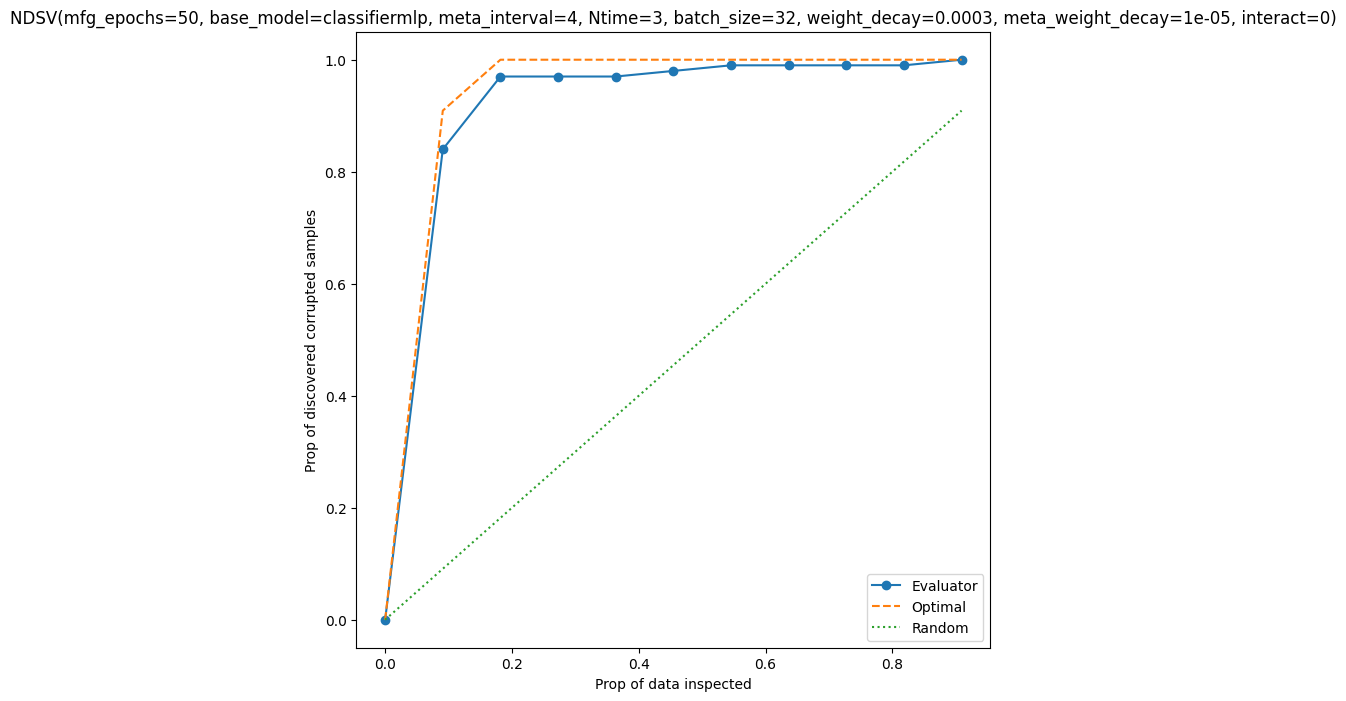

In [9]:
fig = plt.figure(figsize=(18, 8))
df, fig = exper_med.plot(discover_corrupted_sample, fig, col=2, percnet=percent, save_output=True)

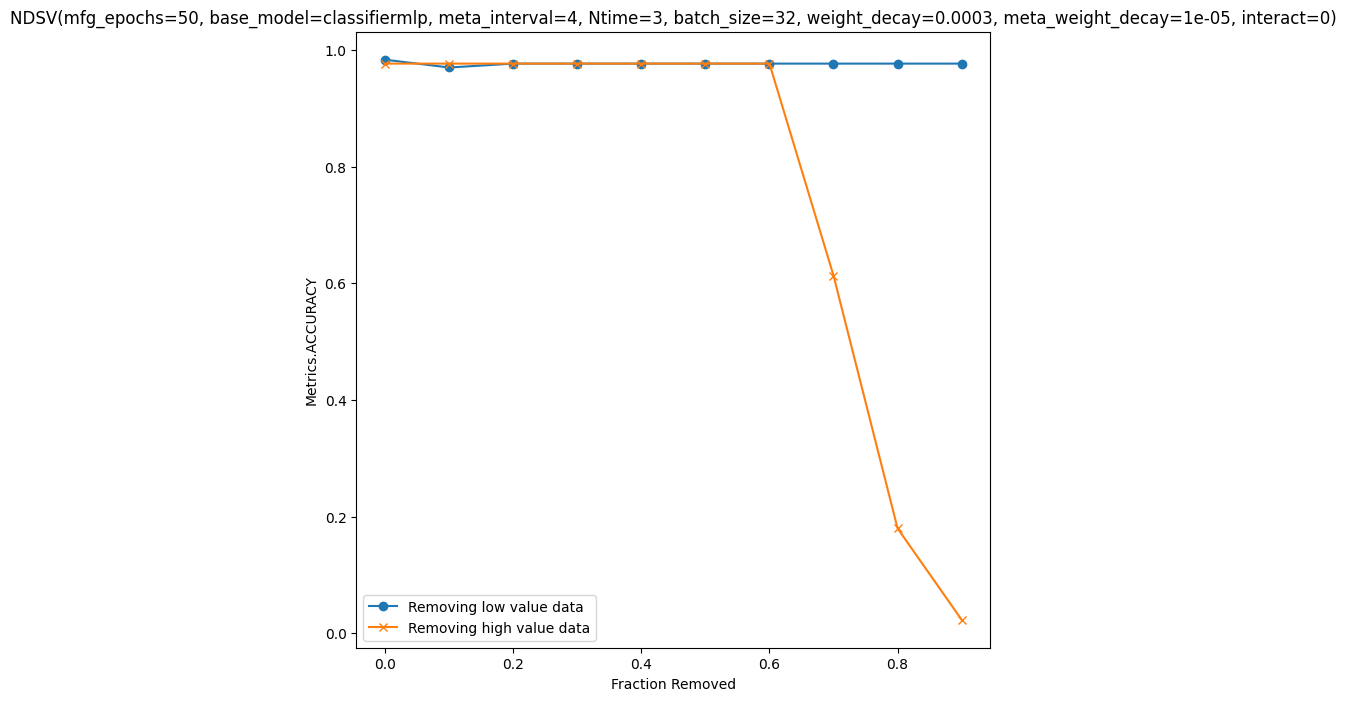

In [10]:
fig = plt.figure(figsize=(18, 8))
df_resp, fig = exper_med.plot(remove_high_low, fig, col=2, percnet=percent, save_output=True)

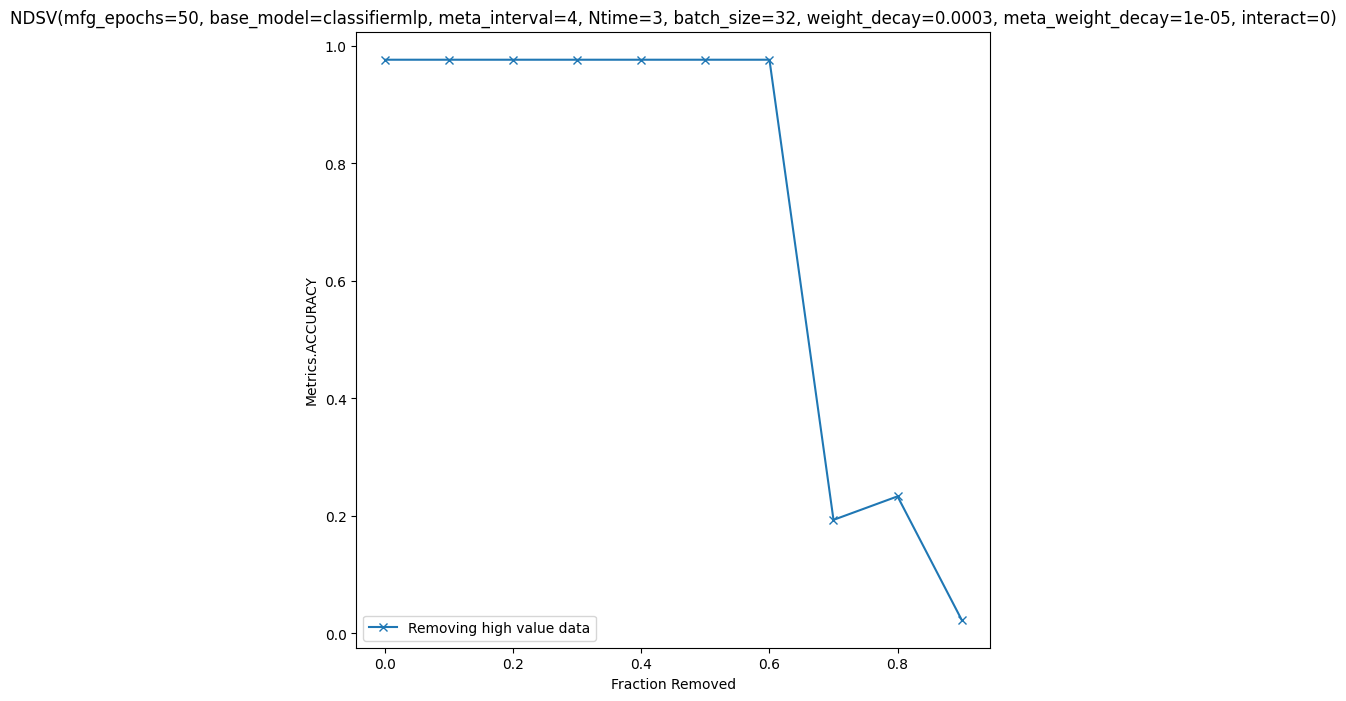

In [11]:
fig = plt.figure(figsize=(18, 8))
df, fig = exper_med.plot(remove_high_value, fig, col=2, percnet=percent, save_output=True)

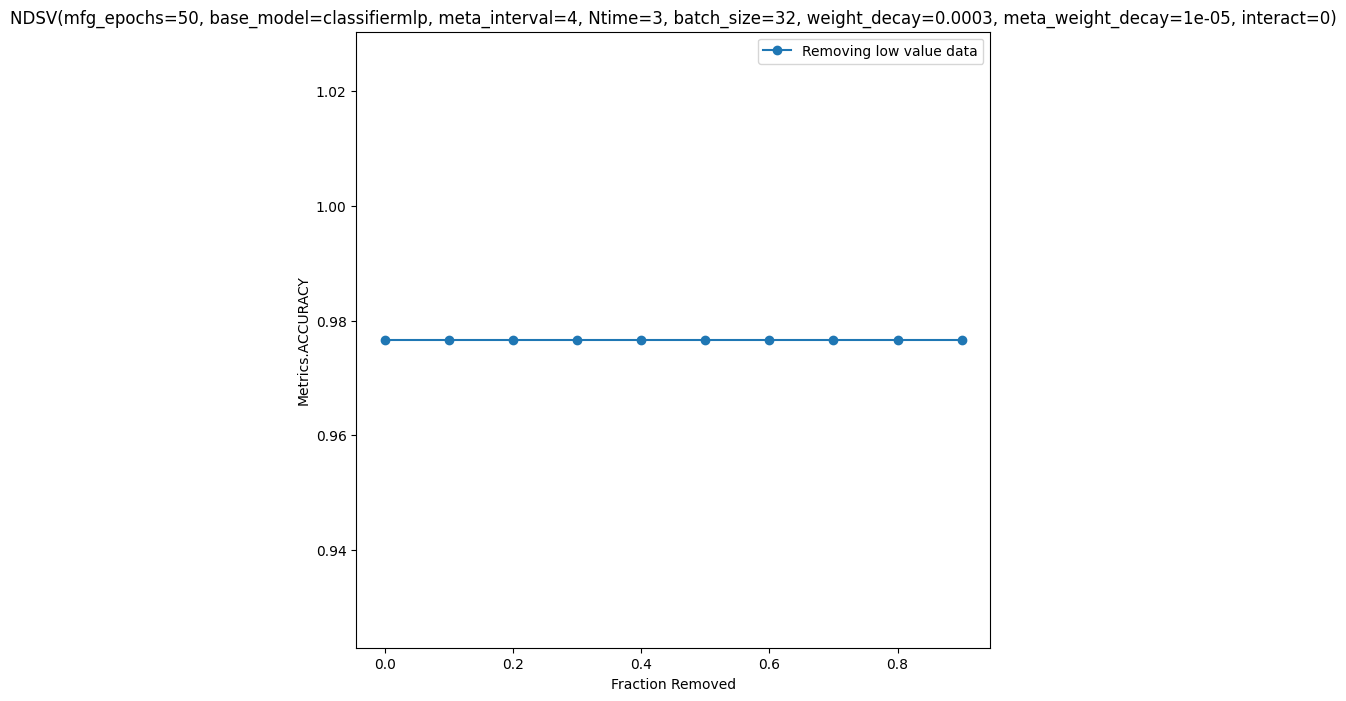

In [12]:
fig = plt.figure(figsize=(18, 8))
df, fig = exper_med.plot(remove_low_value, fig, col=2, percnet=percent, save_output=True)

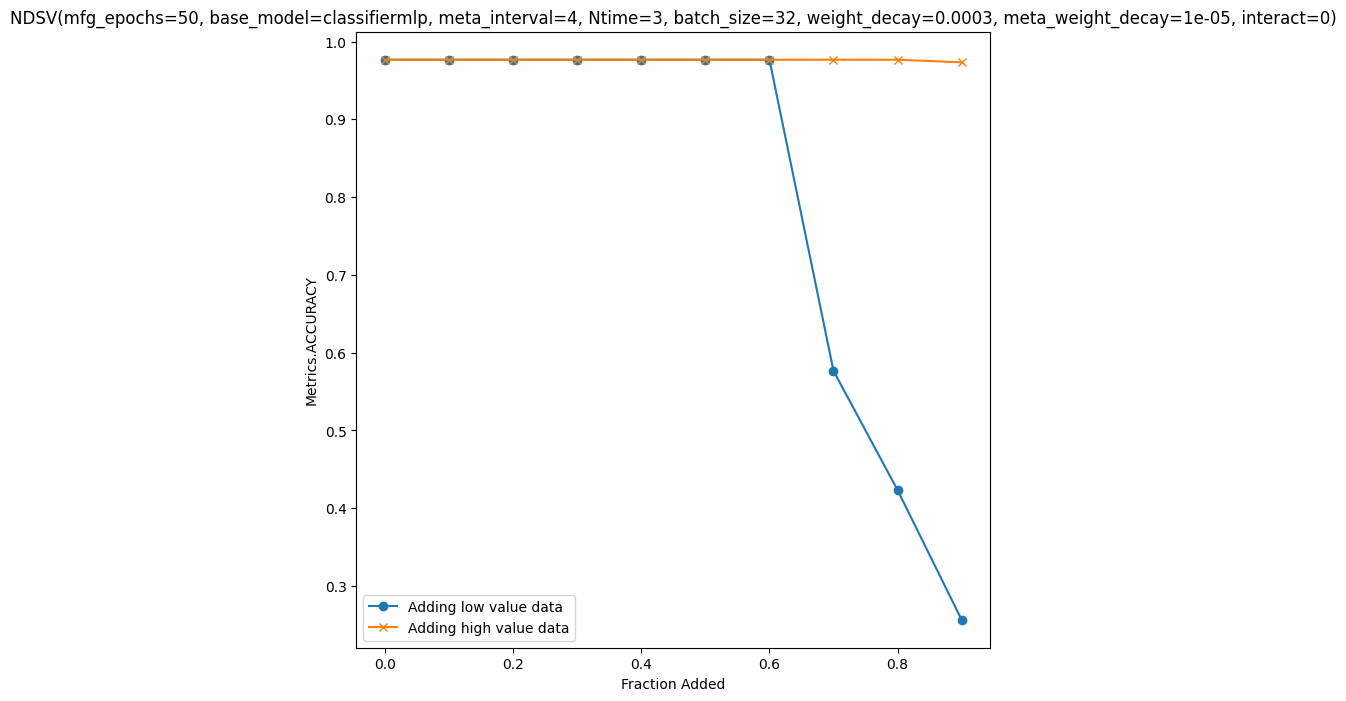

In [13]:
fig = plt.figure(figsize=(18, 8))
df_resp, fig = exper_med.plot(add_low_high, fig, col=2, percnet=percent, save_output=True)

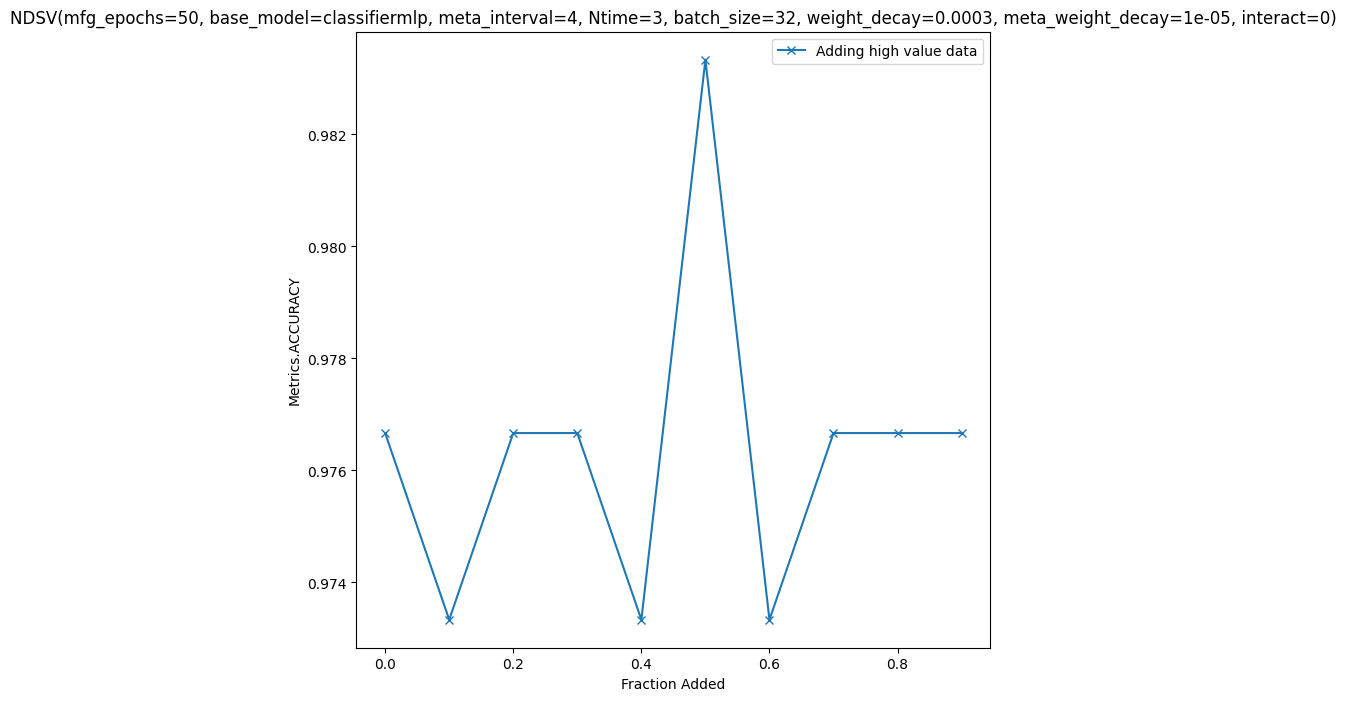

In [14]:
fig = plt.figure(figsize=(18, 8))
df, fig = exper_med.plot(add_high_value, fig, col=2, percnet=percent, save_output=True)

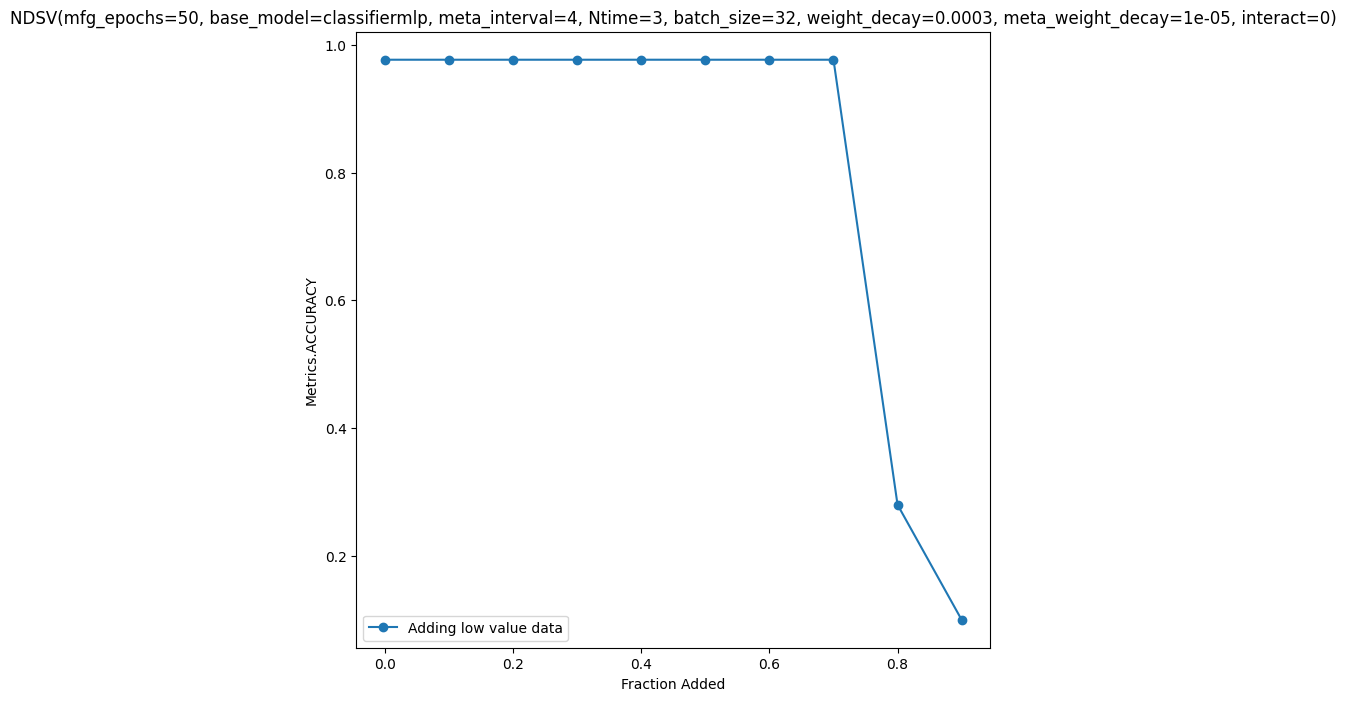

In [15]:
fig = plt.figure(figsize=(18, 8))
df, fig = exper_med.plot(add_low_value, fig, col=2, percnet=percent, save_output=True)

In [16]:
exper_med.evaluate(save_dataval, save_output=True)

,indices,data_values
"NDSV(mfg_epochs=50, base_model=classifiermlp, meta_interval=4, Ntime=3, batch_size=32, weight_decay=0.0003, meta_weight_decay=1e-05, interact=0)",838,0.005423
"NDSV(mfg_epochs=50, base_model=classifiermlp, meta_interval=4, Ntime=3, batch_size=32, weight_decay=0.0003, meta_weight_decay=1e-05, interact=0)",977,0.004723
"NDSV(mfg_epochs=50, base_model=classifiermlp, meta_interval=4, Ntime=3, batch_size=32, weight_decay=0.0003, meta_weight_decay=1e-05, interact=0)",3989,0.001125
"NDSV(mfg_epochs=50, base_model=classifiermlp, meta_interval=4, Ntime=3, batch_size=32, weight_decay=0.0003, meta_weight_decay=1e-05, interact=0)",798,0.004968
"NDSV(mfg_epochs=50, base_model=classifiermlp, meta_interval=4, Ntime=3, batch_size=32, weight_decay=0.0003, meta_weight_decay=1e-05, interact=0)",2174,0.005002
...,...,...
"NDSV(mfg_epochs=50, base_model=classifiermlp, meta_interval=4, Ntime=3, batch_size=32, weight_decay=0.0003, meta_weight_decay=1e-05, interact=0)",2758,0.025659
"NDSV(mfg_epochs=50, base_model=classifiermlp, meta_interval=4, Ntime=3, batch_size=32, weight_decay=0.0003, meta_weight_decay=1e-05, interact=0)",3290,0.025635
"NDSV(mfg_epochs=50, base_model=classifiermlp, meta_interval=4, Ntime=3, batch_size=32, weight_decay=0.0003, meta_weight_decay=1e-05, interact=0)",4082,0.025121
"NDSV(mfg_epochs=50, base_model=classifiermlp, meta_interval=4, Ntime=3, batch_size=32, weight_decay=0.0003, meta_weight_decay=1e-05, interact=0)",3814,0.018243


In [17]:
fetcher = DataFetcher(dataset_name=dataset_name)
fetcher = fetcher.split_dataset_by_count(train_count, valid_count, test_count, meta_count)
x_train, y_train, _, _, _, _ = fetcher.datapoints
print(f"Train: {x_train.shape}, {y_train.shape}")

[7450, 149]
Train: torch.Size([1000, 48]), torch.Size([1000, 2])


In [18]:
label1 = (y_train[:, 0] == 0).nonzero(as_tuple=True)[0]
print(f"Label 1: {label1.shape}")
label2 = (y_train[:, 0] == 1).nonzero(as_tuple=True)[0]
print(f"Label 2: {label2.shape}")

Label 1: torch.Size([980])
Label 2: torch.Size([20])


In [19]:
_, data_state = exper_med.compute_data_state(dynamic_data_state)
print(data_state[-1].shape)

data_state_label1 = data_state[-1][label1]
data_state_label2 = data_state[-1][label2]
print(data_state_label1.shape)
print(data_state_label2.shape)
print(data_state_label1.mean())

(1000, 1)
(980, 1)
(20, 1)
0.15253888


Minimum value in label 1: [-0.6027264]
Maximum value in label 1: [0.675405]
Minimum value in label 2: [-0.15245079]
Maximum value in label 2: [0.48783192]


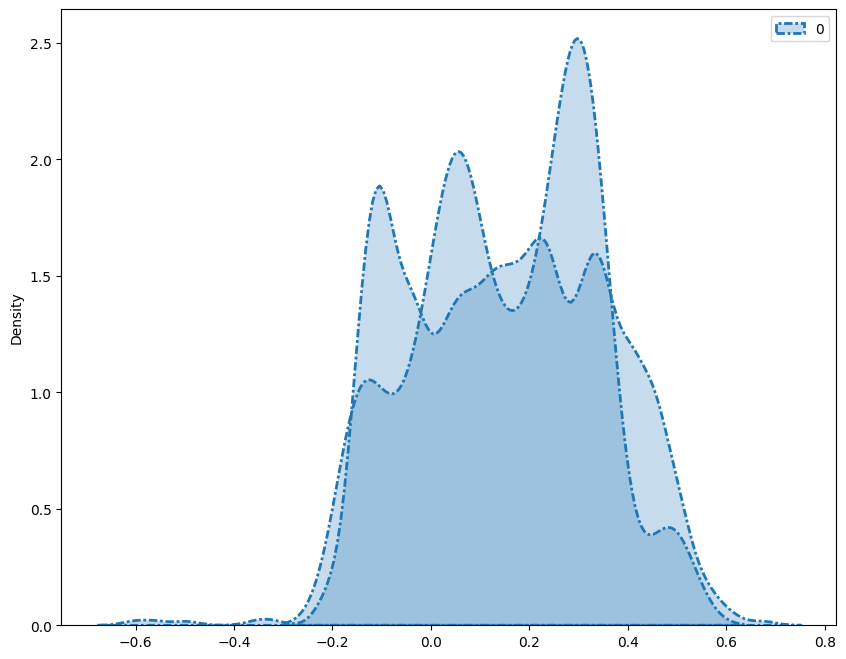

In [20]:
# Plotting the data values distribution

import seaborn as sns
import matplotlib.pyplot as plt

f, ax = plt.subplots(1,figsize=(10, 8))
linestyle = (0, (3, 1, 1, 1))

left_lim = data_state.min() - 0.1
right_lim = data_state.max() + 0.1
abslim = max(np.abs(left_lim), np.abs(right_lim))

sns.kdeplot(data_state_label1, color='darkgreen', linestyle=linestyle, label='Label 1', ax=ax, linewidth=2, fill=True, bw_adjust=0.5)
sns.kdeplot(data_state_label2, color='darkorange', linestyle=linestyle, label='Label 2', ax=ax, linewidth=2, fill=True, bw_adjust=0.5)

# sns.kdeplot(data_state[-1], color='darkgreen', linestyle=linestyle, ax=ax, linewidth=2, fill=True, bw_adjust=0.5)

print("Minimum value in label 1:", min(data_state_label1))
print("Maximum value in label 1:", max(data_state_label1))
print("Minimum value in label 2:", min(data_state_label2))
print("Maximum value in label 2:", max(data_state_label2))


# ax.set_xlim(-abslim, abslim)
# ax.axvline(0, color='black', linewidth=1.8,  linestyle='-', alpha=.6)
# tiks_num=np.linspace(-abslim, abslim, 6)[1:-1]
# ax.set_xticks(tiks_num)
# ax.set_xticklabels([f'{i}' for i in tiks_num])
